In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchmetrics.classification import Dice
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random
import torch
from utils import unet, mypreprocess, util_functions, eff_unet, eff_unet2, my_dataset
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import json
import warnings
warnings.filterwarnings("ignore")
import math
import gc
import albumentations as A
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/scratch/student/sinaziaee/datasets/2d_dataset'
train_dir = os.path.join(base_path, 'training')
valid_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'testing')
IMG_SIZE = 512
BATCH_SIZE = 80

transform_input, transform_output = util_functions.custom_transformers(scale=(0.5, 2), 
                                                    contrast=(0.5, 2), brightness=(0.5, 1.5), rotation=180, blur=1)
aug1_dataset = my_dataset.SegmentationDataset(input_root=f'{train_dir}/images/',target_root=f'{train_dir}/labels/',
                                transform_input= transform_input, transform_target=transform_output)
transform_input, transform_output = util_functions.custom_transformers(scale=(0.7, 1.4), 
                                                    brightness=(0.75, 1.25), contrast=(0.5, 2), rotation=360, blur=1)
aug2_dataset = my_dataset.SegmentationDataset(input_root=f'{train_dir}/images/',target_root=f'{train_dir}/labels/',
                                transform_input= transform_input, transform_target=transform_output)
valid_transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE), 
                                                                                antialias=True)])
plain_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
                            label_dir='labels', data_transformer=valid_transformer, batch_size=BATCH_SIZE, split_size=None)
t_dataset = ConcatDataset([plain_train_loader.dataset, aug1_dataset, aug2_dataset])
# Loaders
train_loader = DataLoader(t_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = mypreprocess.create_data_loaders(path_dir=valid_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=valid_transformer, batch_size=BATCH_SIZE, split_size=None)
test_loader = mypreprocess.create_data_loaders(path_dir=test_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=valid_transformer, batch_size=1, split_size=None)
print("Number of images, training:", len(train_loader.dataset), ", validation", len(valid_loader.dataset), "testing:", len(test_loader.dataset))

dataset info: 
 No images: 13671, No masks: 13671, 
 No of batches: 171, batch shape: torch.Size([80, 1, 512, 512])
dataset info: 
 No images: 1169, No masks: 1169, 
 No of batches: 15, batch shape: torch.Size([80, 1, 512, 512])
dataset info: 
 No images: 941, No masks: 941, 
 No of batches: 941, batch shape: torch.Size([1, 1, 512, 512])
Number of images, training: 41013 , validation 1169 testing: 941


In [3]:
def eval_fn(data_loader, model, criterion, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in data_loader:
            if is_parallel is False:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
            else:
                images, masks = batch[0].to(device_0), batch[1].to(device_1)
            
            outputs = model(images)
            
            if criterion2 == None:
                loss = criterion(outputs, masks)
            else:
                loss = criterion(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            iou = util_functions.calculate_IoU(outputs, masks)
            total_iou += iou.item()
            dice_value = util_functions.dice_coefficient2_modified(loss.item())
        
        avg_loss = total_loss / len(data_loader)
        avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou, dice_value

In [4]:
def train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device,
                                criterion1, criterion2 = None, device_0 = None, device_1 = None, is_parallel=True, scheduler=None):
    if is_parallel is False:
        model = model.to(device)
    else:
        model = nn.DataParallel(model, device_ids=[0, 1])
        
    best_valid_loss = np.Inf

    train_loss_list = []
    valid_loss_list = []
    valid_iou_list = []
    valid_dice_list = []

    results_folder = util_functions.create_result_folder(path='results')
    print(results_folder)
    for epoch in tqdm(range(n_epochs)):
        train_loss = util_functions.train_fn(data_loader=train_loader, model=model, criterion=criterion1, 
                              optimizer=optimizer, device=device, criterion2=criterion2,
                              is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        valid_loss, valid_iou, valid_dice = eval_fn(data_loader=valid_loader, model=model, criterion=criterion1,
                                        device=device, criterion2=criterion2,
                                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        
        scheduler.step()
        
        # Access the current learning rate
        current_lr = scheduler.get_lr()[0]
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_iou_list.append(valid_iou)
        valid_dice_list.append(valid_dice)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            directory = 'results'
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(model.state_dict(), f'{results_folder}/best_model.pt')
            print('SAVED-MODEL')
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Valid IoU: {valid_iou}, lr: {current_lr}')
        if epoch % 10 == 0:
            util_functions.visualize_training(train_loss_list=train_loss_list, valid_loss_list=valid_loss_list,
                                            valid_iou_list=valid_iou_list, valid_dice_list=valid_dice_list, results_folder=results_folder)
            
        lists_dict = {
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list,
            'valid_iou_list': valid_iou_list,
            'valid_dice_list': valid_dice_list,
        }

        with open(f'{results_folder}/training_trend.json', 'w') as f:
            json.dump(lists_dict, f)
        
    return f'{results_folder}/best_model.pt'
                

In [ ]:
torch.cuda.empty_cache()
model = eff_unet2.EffUNet(in_channels=1, classes=1)
device = torch.device('cuda:0')
print(device)
model.to(device)
criterion1 = DiceLoss(mode="binary")
criterion2 = nn.BCEWithLogitsLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau()
n_epochs = 21

result_folder = train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=False, device_0=None, device_1=None, scheduler=scheduler)

In [6]:
print(result_folder)

results/2023-11-15_15-32/best_model.pt


In [10]:
torch.cuda.empty_cache()

In [ ]:
model = eff_unet.EffUNet(in_channels=1, classes=1)
# model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/2023-11-15_15-32/best_model.pt', map_location='cpu'))
device = torch.device('cpu')
t_list = [i for i in range(64)]
with torch.no_grad():
    for idx in t_list:
        data_iter = iter(train_loader)
        images, masks = next(data_iter)
        image = images[idx]
        mask = masks[idx]
        logits_mask = model(image.to(device).unsqueeze(0))
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > 0.5) * 1.0
        util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0), path_dir='results/2023-11-15_15-32/preds', num=idx)

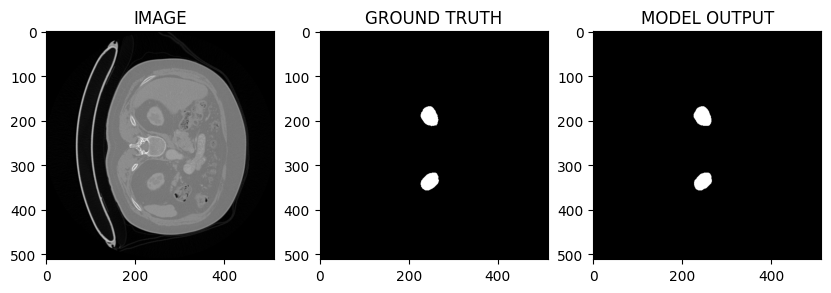

In [13]:
util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [15]:
model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/best_model.pt'))
model = model.to(device)
